In [2]:
#load packages
%matplotlib inline
import pickle
from sklearn import preprocessing

#Load data
with open('../input/msd-fullpickle/msd_full.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

doscaling = 1
if (doscaling == 1):
    xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
    #standardize feature values
    X_train = xscaler.transform(msd_data['X_train'])
    X_test = xscaler.transform(msd_data['X_test'])
else:
    X_train = msd_data['X_train']
    X_test = msd_data['X_test']

Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test'].astype('float32')
X_test = X_test.astype('float32')

y_mean = Y_train.mean()
Y_train_keep = Y_train.copy()
Y_test_keep = Y_test.copy()
Y_train = Y_train - y_mean
Y_test = Y_test - y_mean


#validation is the last 10% of training, subtraining is the first 90% of training
nvalid = int(X_train.shape[0] * 0.1)
nsubtrain = X_train.shape[0] - nvalid

X_subtrain = X_train[0:nsubtrain, :].astype('float32')
X_valid = X_train[nsubtrain:, :].astype('float32')
Y_subtrain = Y_train[0:nsubtrain].astype('float32')
Y_valid = Y_train[nsubtrain:].astype('float32')

Y_subtrain_keep = Y_train_keep[0:nsubtrain].astype('float32')
Y_valid_keep = Y_train_keep[nsubtrain:].astype('float32')

print("X_train shape = ", X_train.shape)
print("X_subtrain shape = ", X_subtrain.shape)
print("X_valid shape = ", X_valid.shape)
print("Y_subtrain shape = ", Y_subtrain.shape)
print("Y_valid shape = ", Y_valid.shape)
print("X_test shape = ", X_test.shape)

X_train shape =  (463715, 90)
X_subtrain shape =  (417344, 90)
X_valid shape =  (46371, 90)
Y_subtrain shape =  (417344,)
Y_valid shape =  (46371,)
X_test shape =  (51630, 90)


### Q1

In [2]:
from sklearn import linear_model
import matplotlib.pyplot as plt

reg = linear_model.LinearRegression()
lm = reg.fit(X_subtrain, Y_subtrain_keep)
print("First 5 coefficients:", lm.coef_[0:5])
pred = lm.predict(X_test)
print("rmse = %f" % ((Y_test_keep - pred) ** 2).mean() ** 0.5)

First 5 coefficients: [ 5.293438  -2.8868432 -1.5276423  0.0630703 -0.3395815]
rmse = 9.509892


### Q2

In [4]:
import torch
from torch.utils import data

class Dataset(data.Dataset):
  def __init__(self, X, Y):
        self.labels = Y
        self.len = X.shape[0]
        self.X = X
        self.Y = Y
        

  def __len__(self):
        return len(list(range(self.len)))

  def __getitem__(self, index):
        X = self.X[index]
        y = self.Y[index]
        return X, y
    
trainset = Dataset(X_train, Y_train)
subtrainset = Dataset(X_subtrain, Y_subtrain)
validset = Dataset(X_valid, Y_valid)
testset = Dataset(X_test, Y_test)

trainloader = data.DataLoader(trainset, batch_size=1000, shuffle=True, num_workers=0)
subtrainloader = data.DataLoader(subtrainset, batch_size=1000, shuffle=True, num_workers=0)
validloader = data.DataLoader(validset, batch_size=5000, shuffle=True, num_workers=0)
testloader = data.DataLoader(testset, batch_size=10000, shuffle=True, num_workers=0)

In [5]:
from livelossplot import PlotLosses

def mlp(net, optimizer, loss_fn = torch.nn.MSELoss(reduction='sum'), 
                           sse_loss_fn = torch.nn.MSELoss(reduction='sum'), nepoch = 100, plot = False):
    net = net.float()
    net = net.to(device)
    
    if plot == True:
        liveloss = PlotLosses(step_names = "Batchs")

    best_valid_mse = float("inf")
    step_count = 0
    train_loss = 0
    train_loss_count = 0
    outer_continue = True
    step = 0
    best_step_count = 0
    best_state = dict()
    for epoch_id in range(0, nepoch):
        if outer_continue == False:
            break        
        for batch_idx, (inputs, targets) in enumerate(subtrainloader):
            targets = targets.reshape((-1, 1))
            step_count += 1
            
            net.train()
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            loss  = sse_loss_fn(outputs, targets) 
            train_loss += loss.item()
            train_loss_count += inputs.shape[0]
            
            if batch_idx % 100 == 0:
                Rmse = {}
                Rmse['rmse'] = (train_loss / train_loss_count) ** 0.5
                train_loss = 0.0
                train_loss_count = 0.0
                
                valid_loss = 0
                valid_num = 0
                net.eval()
                with torch.no_grad():
                    for batch_idx, (inputs, targets) in enumerate(validloader):
                        inputs, targets = inputs.to(device), targets.to(device)
                        targets = targets.reshape((-1, 1))
                        outputs = net(inputs)
                        loss = sse_loss_fn(outputs, targets)    

                        valid_loss += loss.item()
                        valid_num += inputs.shape[0]
                valid_mse = valid_loss / valid_num
                valid_rmse = valid_mse ** 0.5
                Rmse['val_rmse'] = valid_rmse
                
                if plot == True:
                    liveloss.update(Rmse)
                    liveloss.send()

                if valid_mse < best_valid_mse:
                    best_state = {
                        'net': net.state_dict(),
                        'mse': valid_mse,
                        'step_count': step_count,
                    }        
                    best_valid_mse = valid_mse
                    best_step_count = step_count
                    
                if step_count > (best_step_count + 5000):
                    print("early stopping")
                    outer_continue = False
                    break

    net.load_state_dict(best_state['net'])
    net.eval()
    test_loss = 0
    test_num = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):            
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.reshape((-1, 1))
            outputs = net(inputs)
            loss = sse_loss_fn(outputs, targets)   
            test_loss += loss.item() 
            test_num += inputs.shape[0]
            
    test_mse = test_loss / test_num

    print("test rmse= %f \n" %(test_mse ** 0.5))        

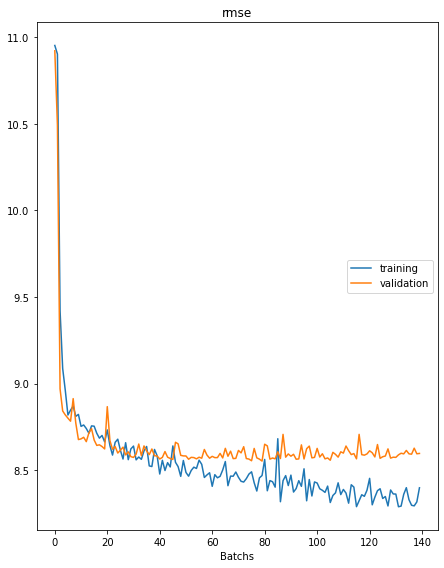

rmse
	training         	 (min:    8.289, max:   10.953, cur:    8.399)
	validation       	 (min:    8.553, max:   10.922, cur:    8.597)
early stopping
test rmse= 8.868823 

CPU times: user 3min 1s, sys: 2.55 s, total: 3min 3s
Wall time: 3min 7s


In [7]:
%%time 


D_in = trainset.X.shape[1]
H = 45
D_out = 1
device = "cuda"

model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),  
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),    
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out),
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0, weight_decay = 0)
mlp(model, optimizer, plot = True)

### Q3

In [8]:
%%time 

Hall = [90, 180]
for H in Hall:
    model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),  
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),    
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out),
    )
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0, weight_decay = 0)
    mlp(model, optimizer)

early stopping
test rmse= 9.042554 

early stopping
test rmse= 9.272898 

CPU times: user 3min 56s, sys: 1.03 s, total: 3min 57s
Wall time: 3min 58s


#### H=45 -> rmse=8.868823
#### H=90 -> rmse=9.042554
#### H=180 -> rmse=9.272898
#### 由上述結果來看，H=45的效果最好，且H愈大，rmse有上升的趨勢。

### Q4

In [9]:
%%time 

Hall = [45, 90, 180]
weight = [0.1, 0.2, 0.4]
for W in weight:
    for H in Hall:
        model = torch.nn.Sequential(
            torch.nn.Linear(D_in, H),  
            torch.nn.ReLU(),
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),    
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            torch.nn.Linear(H, D_out),
        )
        
        optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0, weight_decay = W)
        mlp(model, optimizer)

early stopping
test rmse= 8.957528 

early stopping
test rmse= 9.059607 

early stopping
test rmse= 9.272010 

early stopping
test rmse= 8.934216 

early stopping
test rmse= 8.960979 

early stopping
test rmse= 9.342584 

early stopping
test rmse= 8.855959 

early stopping
test rmse= 9.072884 

early stopping
test rmse= 9.370728 

CPU times: user 20min 18s, sys: 5.46 s, total: 20min 23s
Wall time: 20min 32s


 H | WD=0 | WD=0.1 | WD=0.2 | WD=0.4 |
---|------|--------|--------|--------|
45 |8.868823|8.957528  |8.934216  | 8.855959  |
90 |9.042554|9.059607  |8.960979  | 9.072884 |
180|9.272898|9.272010  |9.342584  | 9.370728 |


#### 由表格來看，H應選45，因為在任何weight decay都能產生較好的rmse

### Q5

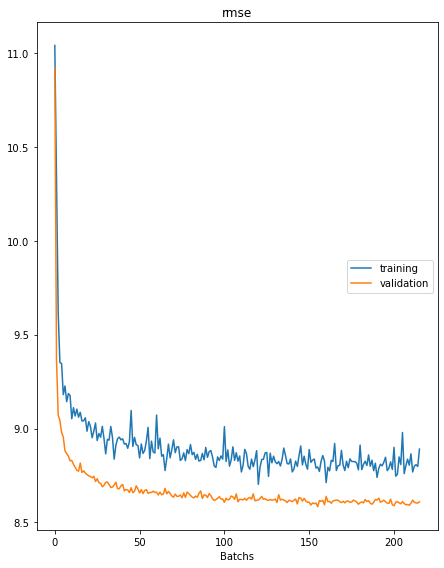

rmse
	training         	 (min:    8.702, max:   11.041, cur:    8.890)
	validation       	 (min:    8.583, max:   10.922, cur:    8.609)
early stopping
test rmse= 8.769739 

CPU times: user 5min, sys: 2.14 s, total: 5min 2s
Wall time: 5min 4s


In [10]:
%%time 

D_in = trainset.X.shape[1]
H = 90
D_out = 1
device = "cuda"

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),  
    torch.nn.ReLU(),
    torch.nn.Dropout(p = 0.5),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Dropout(p = 0.5),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),    
    torch.nn.Dropout(p = 0.5),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Dropout(p = 0.5),      
    torch.nn.Linear(H, D_out),
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

mlp(model, optimizer, plot = True)

#### Training loss一直都在validation loss之上，表示之前overfitting的問題有被解決。

### Q6

In [11]:
%%time 

D_in = trainset.X.shape[1]
D_out = 1
device = "cuda"

Hall = [20, 45, 180, 360]
for H in Hall:
    model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),  
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),    
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.5),      
        torch.nn.Linear(H, D_out),
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    mlp(model, optimizer)

early stopping
test rmse= 8.995854 

early stopping
test rmse= 8.844015 

early stopping
test rmse= 8.728701 

early stopping
test rmse= 8.756170 

CPU times: user 30min 22s, sys: 7.63 s, total: 30min 30s
Wall time: 30min 44s


H  | Test RMSE
---|----------
20 | 8.995854
45 | 8.844015
180| 8.728701
360| 8.756170

#### 看起來H=180有最好的performance。

### Q7

In [6]:
def loss_function(outputs, targets, z = 0.5):
    return z * torch.nn.MSELoss(reduction='sum')(outputs, targets) + (1-z) * torch.nn.L1Loss(reduction = 'sum')(outputs, targets)

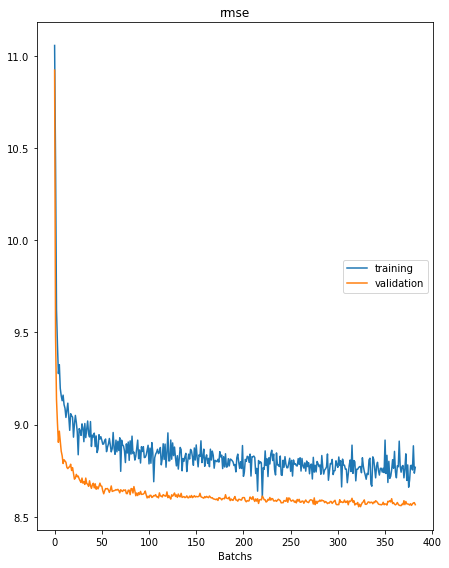

rmse
	training         	 (min:    8.606, max:   11.056, cur:    8.768)
	validation       	 (min:    8.554, max:   10.922, cur:    8.565)
early stopping
test rmse= 8.758431 

CPU times: user 9min, sys: 4 s, total: 9min 4s
Wall time: 9min 7s


In [14]:
%%time

D_in = trainset.X.shape[1]
H = 90
D_out = 1
device = "cuda"

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),  
    torch.nn.ReLU(),
    torch.nn.Dropout(p = 0.5),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Dropout(p = 0.5),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),    
    torch.nn.Dropout(p = 0.5),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Dropout(p = 0.5),      
    torch.nn.Linear(H, D_out),
)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
mlp(model, optimizer, loss_fn = loss_function, plot = True)

In [8]:
%%time

D_in = trainset.X.shape[1]
H = 90
D_out = 1
device = "cuda"


zs = [0., 0.1, 0.9, 1.]

for z in zs:
    model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),  
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),    
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.5),      
        torch.nn.Linear(H, D_out),
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    mlp(model, optimizer, loss_fn = loss_function)

early stopping
test rmse= 9.029827 

early stopping
test rmse= 8.774452 

early stopping
test rmse= 8.797571 

early stopping
test rmse= 8.778967 

CPU times: user 23min 22s, sys: 10.5 s, total: 23min 33s
Wall time: 23min 52s


z   | RMSE
----|--------------
0   | 9.029827
0.1 |8.774452
0.5 |8.758431 
0.9 |8.797571
1.0 |8.778967

#### 只有使用L1 loss是表現最差的，而z=0.5時，表現最好。

## Q8

In [14]:
def customerized(inputs, targets, q = 0.5):
    e1 = inputs - targets 
    return (torch.max(q*e1, (q-1)*e1)).sum()

def loss_function(outputs, targets, z = 0):
        return z * torch.nn.MSELoss(reduction='sum')(outputs, targets) + (1-z) * customerized(outputs, targets, q = 0.5)

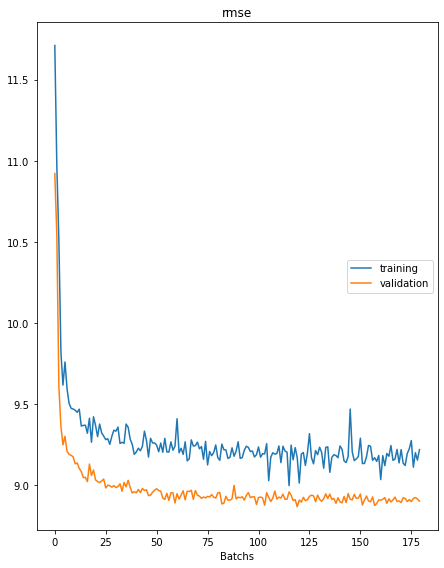

rmse
	training         	 (min:    8.997, max:   11.711, cur:    9.218)
	validation       	 (min:    8.867, max:   10.921, cur:    8.901)
early stopping
test rmse= 9.010789 

CPU times: user 4min 53s, sys: 1.83 s, total: 4min 55s
Wall time: 4min 58s


In [15]:
%%time


D_in = trainset.X.shape[1]
H = 90
D_out = 1
device = "cuda"


model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),  
    torch.nn.ReLU(),
    torch.nn.Dropout(p = 0.5),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Dropout(p = 0.5),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),    
    torch.nn.Dropout(p = 0.5),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Dropout(p = 0.5),      
    torch.nn.Linear(H, D_out),
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
mlp(model, optimizer, loss_fn = loss_function, plot = True)

In [19]:
%%time

D_in = trainset.X.shape[1]
H = 90
D_out = 1
device = "cuda"

zs = [0.1, 0.5,  0.9, 1.0]

for z in zs:
    def loss_function(outputs, targets, z = z):
        return z * torch.nn.MSELoss(reduction='sum')(outputs, targets) + (1-z) * customerized(outputs, targets, q = 0.5)
    
    model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),  
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),    
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.5),      
        torch.nn.Linear(H, D_out),
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    mlp(model, optimizer, loss_fn = loss_function)

early stopping
test rmse= 8.758675 

early stopping
test rmse= 8.765805 

early stopping
test rmse= 8.762174 

early stopping
test rmse= 8.788788 

CPU times: user 35min 24s, sys: 7.51 s, total: 35min 32s
Wall time: 35min 53s


z    |   Test RMSE
-----|-------------
0    | 9.010789 
0.1  | 8.758675
0.5  | 8.765805 
0.9  | 8.762174 
1.0  | 8.788788

#### z=0時結果最差，而z=0.1時結果最好。